In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from classes.QLearningAgentClass import QLearningAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_grids, plot_trajectory
from utilities.jsonRW import writeJSON, readJSON

In [2]:
shape="5x5"

env = createNNEnv(shape)

Loading models...
Models loaded


In [3]:
# hyperparameters
if shape == "5x5":
    n_episodes = 5000
elif shape == "14x14":
    n_episodes = 15000

learning_rate = 0.02
start_epsilon = 1.0
epsilon_decay = start_epsilon/(n_episodes/2)  # reduce the exploration over time
final_epsilon = 0.1
discount_factor = 0.95

agent = QLearningAgent(env, n_episodes, learning_rate, start_epsilon, epsilon_decay, final_epsilon, discount_factor)

In [4]:
agent.train()

100%|██████████| 5000/5000 [00:18<00:00, 265.51it/s]


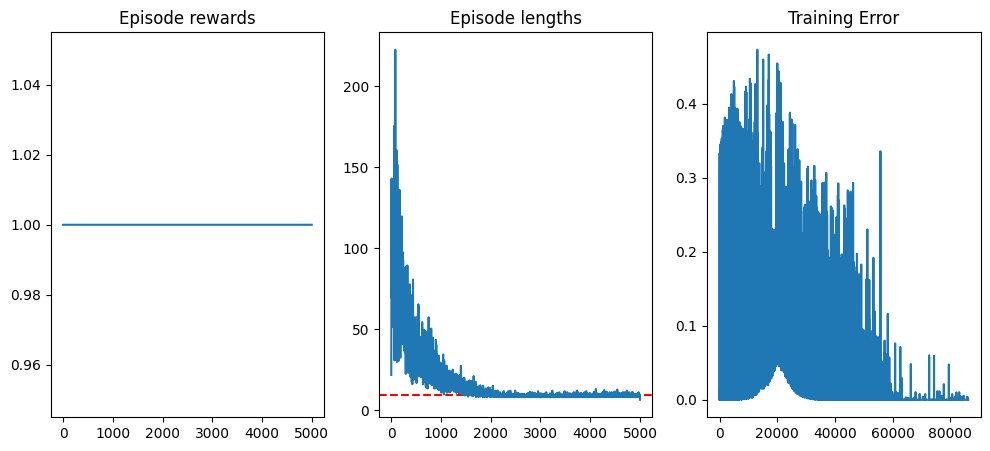

In [5]:
fig = agent.plot_results()
plt.show()

In [6]:
value_grid, policy_grid, string_policy_grid = create_grids(env, agent=agent)
#print(string_policy_grid)

writeJSON("Q-Learning", n_episodes, 0, shape, env.unwrapped.start_pos, value_grid, policy_grid, string_policy_grid)

#fig = plot_trajectory(string_policy_grid, env.unwrapped.start_pos)
#plt.show()

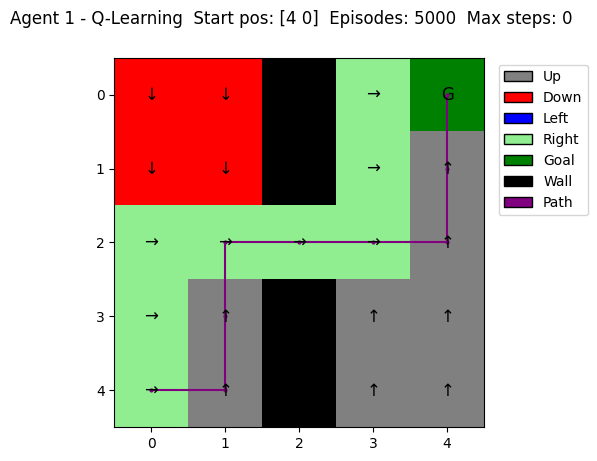

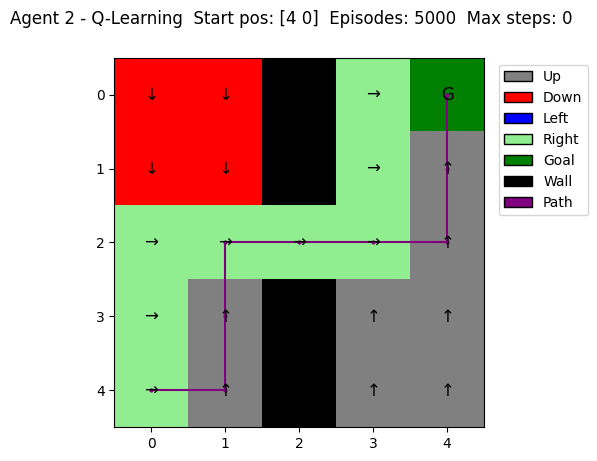

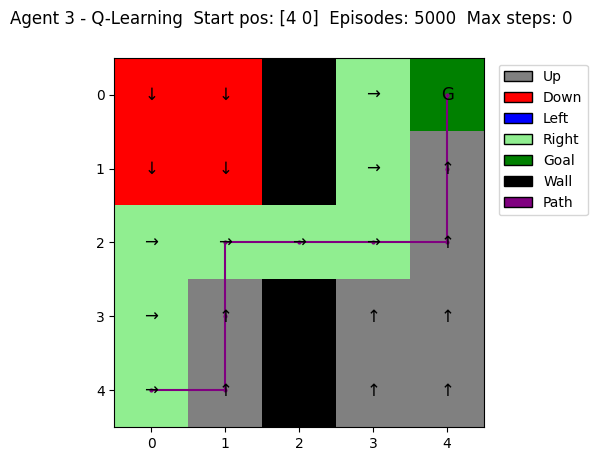

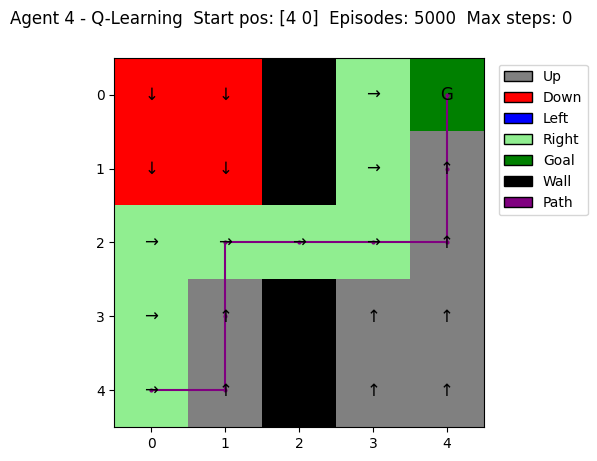

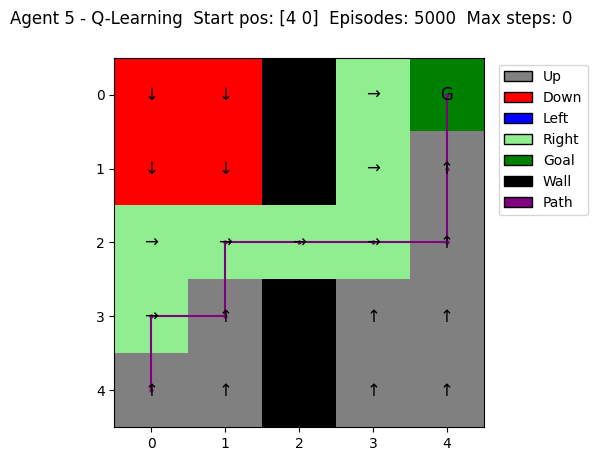

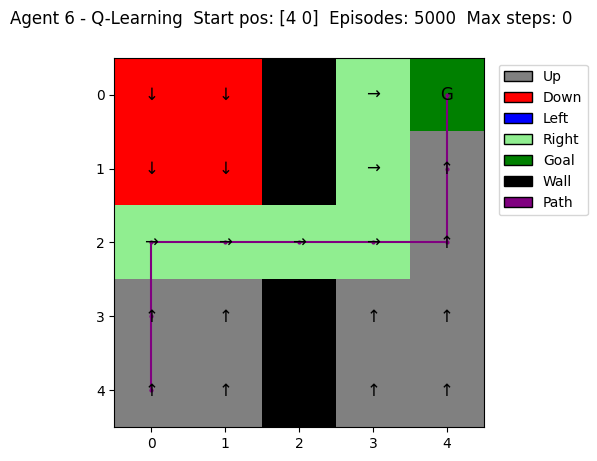

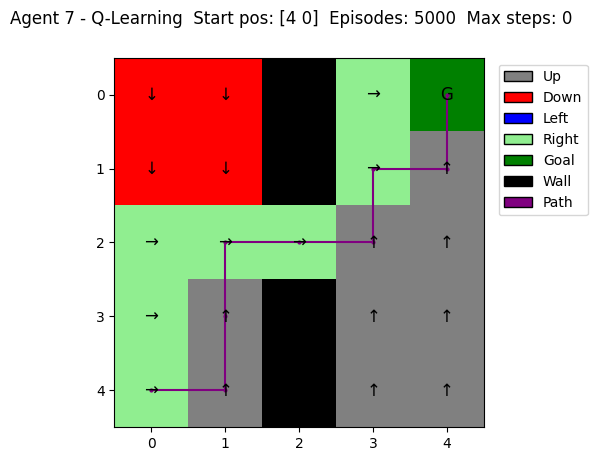

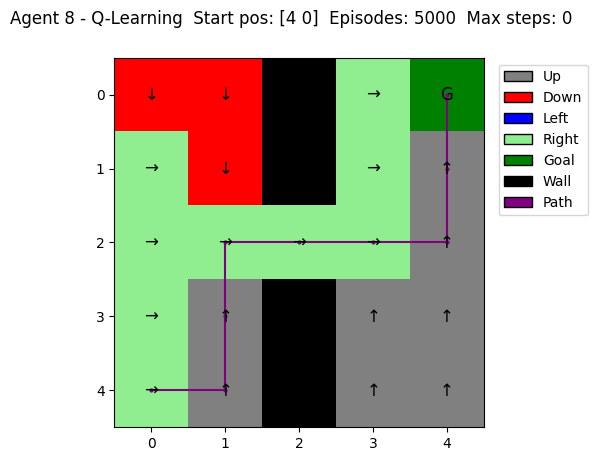

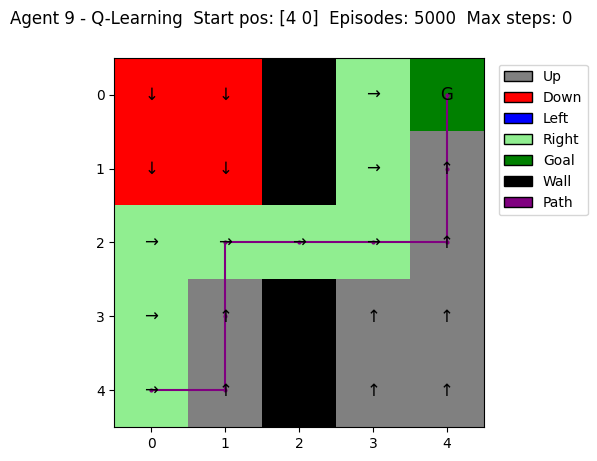

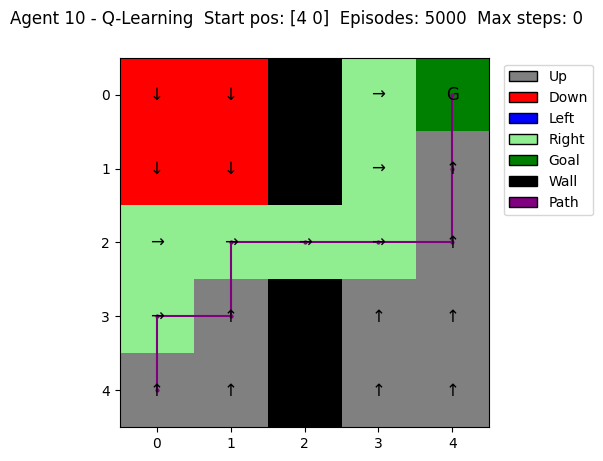

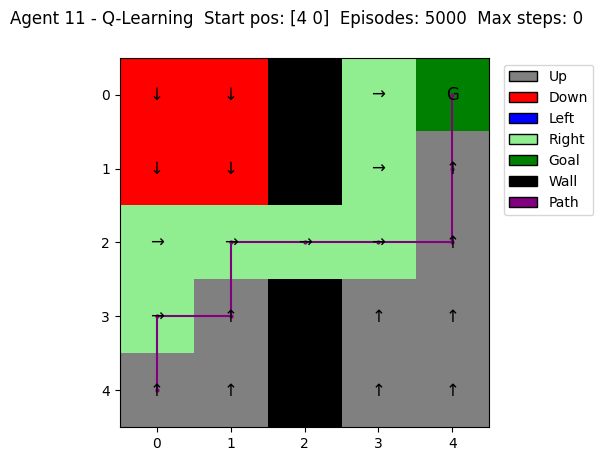

In [7]:
readJSON("Q-Learning", shape)